### ecdsa

In [9]:
import hashlib
from hmac import HMAC
from hashlib import sha256

Pcurve = 0xffffffff00000001000000000000000000000000ffffffffffffffffffffffff  # The proven prime
N = 0xffffffff00000000ffffffffffffffffbce6faada7179e84f3b9cac2fc632551 # Number of points in the field
Acurve = 0xffffffff00000001000000000000000000000000fffffffffffffffffffffffc
Bcurve = 0x5ac635d8aa3a93e7b3ebbd55769886bc651d06b0cc53b0f63bce3c3e27d2604b  # This defines the curve. y^2 = x^3 + Acurve * x + Bcurve
Gx = 0x6b17d1f2e12c4247f8bce6e563a440f277037d812deb33a0f4a13945d898c296
Gy = 0x4fe342e2fe1a7f9b8ee7eb4a7c0f9e162bce33576b315ececbb6406837bf51f5
GPoint = (Gx, Gy)  # This is our generator point. Tillions of dif ones possible

def modinv(a, n=Pcurve):  # Extended Euclidean Algorithm/'division' in elliptic curves
    lm, hm = 1, 0
    low, high = a % n, n
    while low > 1:
        ratio = high // low  # Use integer division operator for Python 3.x
        nm, new = hm - lm * ratio, high - low * ratio
        lm, low, hm, high = nm, new, lm, low
    return lm % n


def ECadd(xp, yp, xq, yq):  # Not true addition, invented for EC. It adds Point-P with Point-Q.
    m = ((yq - yp) * modinv(xq - xp, Pcurve)) % Pcurve
    xr = (m * m - xp - xq) % Pcurve
    yr = (m * (xp - xr) - yp) % Pcurve
    return (xr, yr)


def ECdouble(xp, yp):  # EC point doubling, invented for EC. It doubles Point-P.
    LamNumer = 3 * xp * xp + Acurve
    LamDenom = 2 * yp
    Lam = (LamNumer * modinv(LamDenom, Pcurve)) % Pcurve
    xr = (Lam * Lam - 2 * xp) % Pcurve
    yr = (Lam * (xp - xr) - yp) % Pcurve
    return (xr, yr)


def EccMultiply(xs, ys, Scalar):  # Double & add. EC Multiplication, Not true multiplication
    if Scalar == 0 or Scalar >= N:
        raise Exception("Invalid Scalar/Private Key")
    ScalarBin = str(bin(Scalar))[2:]
    Qx, Qy = xs, ys
    for i in range(1, len(ScalarBin)):  # This is invented EC multiplication.
        Qx, Qy = ECdouble(Qx, Qy)
        if ScalarBin[i] == "1":
            Qx, Qy = ECadd(Qx, Qy, xs, ys)
    return (Qx, Qy)

def deterministic_generate_k(msghash, privkey):
    # Step 1: Prepare the key and message
    V = b'\x01' * 32
    K = b'\x00' * 32
    privkey = privkey.to_bytes(32, 'big')
    msghash = msghash.to_bytes(32, 'big')

    # Step 2: Generate the K value
    K = HMAC(K, V + b'\x00' + privkey + msghash, sha256).digest()
    V = HMAC(K, V, sha256).digest()
    K = HMAC(K, V + b'\x01' + privkey + msghash, sha256).digest()
    V = HMAC(K, V, sha256).digest()

    # Step 3: Convert the K value to an integer
    while True:
        t = b''
        while len(t) < 32:
            V = HMAC(K, V, sha256).digest()
            t += V
        k = int.from_bytes(t[:32], 'big')
        if k >= 1 and k < N:
            return k


def ECDSA_verify(message, r, s, xPublicKey, yPublicKey):
    # Step 1: Compute the deterministic k value
    HashOfThingToSign = int(hashlib.sha256(message.encode()).hexdigest(), 16)
    k = deterministic_generate_k(HashOfThingToSign, xPublicKey)

    # Step 2: Compute w
    w = modinv(s, N)

    # Step 3: Compute u1 and u2
    xu1, yu1 = EccMultiply(Gx, Gy, (HashOfThingToSign * w) % N)
    xu2, yu2 = EccMultiply(xPublicKey, yPublicKey, (r * w) % N)

    # Step 4: Compute the verification point (x, y)
    x, y = ECadd(xu1, yu1, xu2, yu2)

    # Step 5: Check if r equals x
    return r == x


### subscriber

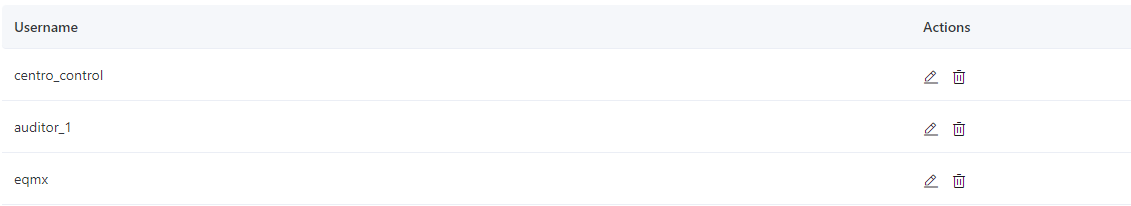

In [1]:
from paho.mqtt import client as mqtt_client
import random
import ssl

broker = 'cf1ce048.ala.us-east-1.emqxsl.com'
port = 8883
topic = "cripto_test"# generate client ID with pub prefix randomly
client_id = f'python-mqtt-{random.randint(0, 100)}'
# username = 'emqx'
# password = 'public'

# List to store received messages
received_messages = []

def connect_mqtt() -> mqtt_client:
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print("Failed to connect, return code %d\n", rc)

    client = mqtt_client.Client(client_id)
    client.username_pw_set("auditor_1", "poner_una_contraseña_muy_segura1")
    client.on_connect = on_connect
    client.tls_set(ca_certs="C:\\Users\\Alfre\\Downloads\\emqxsl-ca.crt", 
                tls_version=ssl.PROTOCOL_TLSv1_2)

    client.connect(broker, port)

    
    return client


def subscribe(client: mqtt_client):
    def on_message(client, userdata, msg):
        message = f"Received `{msg.payload.decode()}` from `{msg.topic}` topic\n"
        received_messages.append(msg.payload.decode())  # Append the message to the list
        print(message)

    client.subscribe(topic)
    client.on_message = on_message


In [2]:
client = connect_mqtt()
subscribe(client)
# Run an infinite loop to continuously listen for MQTT messages
try:
    client.loop_forever()
except KeyboardInterrupt:
    client.disconnect()

Connected to MQTT Broker!
Received `{"encrypted_data": "*\u00be\u00d3\u00e9\u0002t1n\u001e)/\u00b3\u00d4\u00e8\u0015\u00a2co\u00fc\u00bf\u00a3\u009f\u00ce\u00d9%A\r\u00db\u00f5\u00d5\u0080\u0012\u0006\u00c8|?\u00cf\u0015j\u00a4,qp\u00f3\u00c2\u00896\u00cf\u00f7\u0099\u00cb\u00144u\u0080\u0002\u00a4\u0092\u00fd\u00b5\u00b9\\\u00d4\u00d4\u00d2\\\u00c3\u00cf\u00a3'\u00e1/\u00ed95\u00b1\t\u00e5\u00a29+\u0005y\u0010\u00f3\u008b<Q\u00da\u00cb\u00fa\u00a0\u007f\u00ea1S", "iv": "\u008e\u001f\u0088!\u0082\u00f2Ga\u009e`\u001eV\u0013\u0011lv", "r": "0x5e43d3f6326149fd7ea4aa946b66e742f6f18e8797244839d0593d6b9b838424", "s": "0x66ffad681da4a744b12d56a671a156dcad016163fdf36fecde5f1465a56736b1"}` from `cripto_test` topic

Received `{"encrypted_data": "\n\u00b8\u009d\u00b0[$\u00b9\u0081\u00fa^\u0000\u00ee\u00ca\u0085\u0016\u008b\u00a1%#\u0011\u00f7\u00a6\u0097\u00ad\u00de\u00ea\u00a8\u008fh\u00d6\u00af\u0091\u00ab\u0002\u00e7\u00fd\f'(\u001f\u00b7\u0096\u00d3x\u00bf\u0002=r\u00bb\u00c2\u0012\u00ce6\u0

In [22]:
received_messages

['{"encrypted_data": "*\\u00be\\u00d3\\u00e9\\u0002t1n\\u001e)/\\u00b3\\u00d4\\u00e8\\u0015\\u00a2co\\u00fc\\u00bf\\u00a3\\u009f\\u00ce\\u00d9%A\\r\\u00db\\u00f5\\u00d5\\u0080\\u0012\\u0006\\u00c8|?\\u00cf\\u0015j\\u00a4,qp\\u00f3\\u00c2\\u00896\\u00cf\\u00f7\\u0099\\u00cb\\u00144u\\u0080\\u0002\\u00a4\\u0092\\u00fd\\u00b5\\u00b9\\\\\\u00d4\\u00d4\\u00d2\\\\\\u00c3\\u00cf\\u00a3\'\\u00e1/\\u00ed95\\u00b1\\t\\u00e5\\u00a29+\\u0005y\\u0010\\u00f3\\u008b<Q\\u00da\\u00cb\\u00fa\\u00a0\\u007f\\u00ea1S", "iv": "\\u008e\\u001f\\u0088!\\u0082\\u00f2Ga\\u009e`\\u001eV\\u0013\\u0011lv", "r": "0x5e43d3f6326149fd7ea4aa946b66e742f6f18e8797244839d0593d6b9b838424", "s": "0x66ffad681da4a744b12d56a671a156dcad016163fdf36fecde5f1465a56736b1"}',
 '{"encrypted_data": "\\n\\u00b8\\u009d\\u00b0[$\\u00b9\\u0081\\u00fa^\\u0000\\u00ee\\u00ca\\u0085\\u0016\\u008b\\u00a1%#\\u0011\\u00f7\\u00a6\\u0097\\u00ad\\u00de\\u00ea\\u00a8\\u008fh\\u00d6\\u00af\\u0091\\u00ab\\u0002\\u00e7\\u00fd\\f\'(\\u001f\\u00b7\\u0096\\u

In [13]:
import json
received_messages_json = [json.loads(msg) for msg in received_messages]

In [24]:
#create another dictionary with encrypted_data and iv for all messages
messages_to_verify = []

for dict in received_messages_json:
    new_dict = {
        key: value
        for key, value in dict.items()
        if key in ('encrypted_data', 'iv')
    }
    messages_to_verify.append(new_dict)

In [29]:
messages_to_verify[0]

{'encrypted_data': "*¾Óé\x02t1n\x1e)/³Ôè\x15¢coü¿£\x9fÎÙ%A\rÛõÕ\x80\x12\x06È|?Ï\x15j¤,qpóÂ\x896Ï÷\x99Ë\x144u\x80\x02¤\x92ýµ¹\\ÔÔÒ\\ÃÏ£'á/í95±\tå¢9+\x05y\x10ó\x8b<QÚËú\xa0\x7fê1S",
 'iv': '\x8e\x1f\x88!\x82òGa\x9e`\x1eV\x13\x11lv'}

In [88]:
#received_messages_json[0]['r']

#convert r and s to hexadecimal
type(int(received_messages_json[0]['r'], 16))

int

In [53]:
int(received_messages_json[0]['r'], 16)

42637249426098882151823241663684688864511193666012014474351159734836152992804

In [54]:
xPublicKey, yPublicKey = 0x60fed4ba255a9d31c961eb74c6356d68c049b8923b61fa6ce669622e60f29fb6, 0x7903fe1008b8bc99a41ae9e95628bc64f2f1b20c2d7e9f5177a3c294d4462299

valid_traces = []

for i in range(len(received_messages_json)):
    valid_signature = ECDSA_verify(str(messages_to_verify[i]), int(received_messages_json[i]['r'], 16), int(received_messages_json[i]['s'], 16), xPublicKey, yPublicKey)
    #print(valid_signature)
    if valid_signature:
        valid_traces.append(messages_to_verify[i])
        print("Valid Signature")
    else:
        print("Invalid Signature")

Valid Signature
Valid Signature
Valid Signature
Valid Signature
Valid Signature
Valid Signature
Valid Signature
Valid Signature
Valid Signature
Valid Signature


In [56]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding

# Decrypt the encrypted data using AES-CBC
def decrypt_data(key, iv, ciphertext):
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    decryptor = cipher.decryptor()

    # Decrypt the ciphertext
    decrypted_data = decryptor.update(ciphertext) + decryptor.finalize()

    # Unpad the decrypted data
    unpadder = padding.PKCS7(128).unpadder()
    unpadded_data = unpadder.update(decrypted_data) + unpadder.finalize()
    return unpadded_data

In [63]:
key = b'0123456789ABCDEF0123456789ABCDEF' #llave compartida previamente por el canal seguro

decrypted_data_valid_traces = []
# Decrypt and print each trace
for encrypted_trace in valid_traces:
    ciphertext = encrypted_trace['encrypted_data'].encode('latin-1')
    iv = encrypted_trace['iv'].encode('latin-1')
    decrypted_data = decrypt_data(key, iv, ciphertext)
    decrypted_data_valid_traces.append(decrypted_data.decode('latin-1'))
    print("Decrypted Data:", decrypted_data.decode())

Decrypted Data: "trace_id": "011", "timestamp": "2013-11-02T00:00:00Z", "C(0)/P(1)": "0", "value": 58.0
Decrypted Data: "trace_id": "012", "timestamp": "2013-11-02T00:15:00Z", "C(0)/P(1)": "0", "value": 75.0
Decrypted Data: "trace_id": "013", "timestamp": "2013-11-02T00:30:00Z", "C(0)/P(1)": "0", "value": 65.0
Decrypted Data: "trace_id": "014", "timestamp": "2013-11-02T00:45:00Z", "C(0)/P(1)": "0", "value": 0.08
Decrypted Data: "trace_id": "015", "timestamp": "2013-11-02T01:00:00Z", "C(0)/P(1)": "0", "value": 67.0
Decrypted Data: "trace_id": "016", "timestamp": "2013-11-02T01:15:00Z", "C(0)/P(1)": "0", "value": 69.0
Decrypted Data: "trace_id": "017", "timestamp": "2013-11-02T01:30:00Z", "C(0)/P(1)": "0", "value": 0.07
Decrypted Data: "trace_id": "018", "timestamp": "2013-11-02T01:45:00Z", "C(0)/P(1)": "0", "value": 73.0
Decrypted Data: "trace_id": "019", "timestamp": "2013-11-02T02:00:00Z", "C(0)/P(1)": "0", "value": 68.0
Decrypted Data: "trace_id": "0110", "timestamp": "2013-11-02T02:

In [71]:
decrypted_data_valid_traces = [item.replace("'", "") for item in decrypted_data_valid_traces]
print(decrypted_data_valid_traces)

['"trace_id": "011", "timestamp": "2013-11-02T00:00:00Z", "C(0)/P(1)": "0", "value": 58.0', '"trace_id": "012", "timestamp": "2013-11-02T00:15:00Z", "C(0)/P(1)": "0", "value": 75.0', '"trace_id": "013", "timestamp": "2013-11-02T00:30:00Z", "C(0)/P(1)": "0", "value": 65.0', '"trace_id": "014", "timestamp": "2013-11-02T00:45:00Z", "C(0)/P(1)": "0", "value": 0.08', '"trace_id": "015", "timestamp": "2013-11-02T01:00:00Z", "C(0)/P(1)": "0", "value": 67.0', '"trace_id": "016", "timestamp": "2013-11-02T01:15:00Z", "C(0)/P(1)": "0", "value": 69.0', '"trace_id": "017", "timestamp": "2013-11-02T01:30:00Z", "C(0)/P(1)": "0", "value": 0.07', '"trace_id": "018", "timestamp": "2013-11-02T01:45:00Z", "C(0)/P(1)": "0", "value": 73.0', '"trace_id": "019", "timestamp": "2013-11-02T02:00:00Z", "C(0)/P(1)": "0", "value": 68.0', '"trace_id": "0110", "timestamp": "2013-11-02T02:15:00Z", "C(0)/P(1)": "0", "value": 0.06']


In [74]:
type(decrypted_data_valid_traces[0])

str

In [64]:
decrypted_data_valid_traces

['"trace_id": "011", "timestamp": "2013-11-02T00:00:00Z", "C(0)/P(1)": "0", "value": 58.0',
 '"trace_id": "012", "timestamp": "2013-11-02T00:15:00Z", "C(0)/P(1)": "0", "value": 75.0',
 '"trace_id": "013", "timestamp": "2013-11-02T00:30:00Z", "C(0)/P(1)": "0", "value": 65.0',
 '"trace_id": "014", "timestamp": "2013-11-02T00:45:00Z", "C(0)/P(1)": "0", "value": 0.08',
 '"trace_id": "015", "timestamp": "2013-11-02T01:00:00Z", "C(0)/P(1)": "0", "value": 67.0',
 '"trace_id": "016", "timestamp": "2013-11-02T01:15:00Z", "C(0)/P(1)": "0", "value": 69.0',
 '"trace_id": "017", "timestamp": "2013-11-02T01:30:00Z", "C(0)/P(1)": "0", "value": 0.07',
 '"trace_id": "018", "timestamp": "2013-11-02T01:45:00Z", "C(0)/P(1)": "0", "value": 73.0',
 '"trace_id": "019", "timestamp": "2013-11-02T02:00:00Z", "C(0)/P(1)": "0", "value": 68.0',
 '"trace_id": "0110", "timestamp": "2013-11-02T02:15:00Z", "C(0)/P(1)": "0", "value": 0.06']

In [79]:
# Remove the single quotes ('') from the strings
data = [s.replace("'", "") for s in decrypted_data_valid_traces]

# Convert the list of strings into a list of dictionaries
result = [json.loads("{" + s + "}") for s in decrypted_data_valid_traces]

In [84]:
result

[{'trace_id': '011',
  'timestamp': '2013-11-02T00:00:00Z',
  'C(0)/P(1)': '0',
  'value': 58.0},
 {'trace_id': '012',
  'timestamp': '2013-11-02T00:15:00Z',
  'C(0)/P(1)': '0',
  'value': 75.0},
 {'trace_id': '013',
  'timestamp': '2013-11-02T00:30:00Z',
  'C(0)/P(1)': '0',
  'value': 65.0},
 {'trace_id': '014',
  'timestamp': '2013-11-02T00:45:00Z',
  'C(0)/P(1)': '0',
  'value': 0.08},
 {'trace_id': '015',
  'timestamp': '2013-11-02T01:00:00Z',
  'C(0)/P(1)': '0',
  'value': 67.0},
 {'trace_id': '016',
  'timestamp': '2013-11-02T01:15:00Z',
  'C(0)/P(1)': '0',
  'value': 69.0},
 {'trace_id': '017',
  'timestamp': '2013-11-02T01:30:00Z',
  'C(0)/P(1)': '0',
  'value': 0.07},
 {'trace_id': '018',
  'timestamp': '2013-11-02T01:45:00Z',
  'C(0)/P(1)': '0',
  'value': 73.0},
 {'trace_id': '019',
  'timestamp': '2013-11-02T02:00:00Z',
  'C(0)/P(1)': '0',
  'value': 68.0},
 {'trace_id': '0110',
  'timestamp': '2013-11-02T02:15:00Z',
  'C(0)/P(1)': '0',
  'value': 0.06}]

In [87]:
import pandas as pd

# Assuming you have already obtained the 'result' list of dictionaries

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(result)

#export to a csv file
df.to_csv('decrypted_data_valid_traces.csv', index=False)